In [1]:
import pandas as pb
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

In [2]:
Customers = pb.read_csv('Customers.csv')
Transactions = pb.read_csv('Transactions.csv')

In [3]:
CustomerTransactions = pb.merge(Customers,Transactions,on='CustomerID',how='inner')
CustomerTransactions.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [4]:
CustomerTransactions['SignupDate'] = pb.to_datetime(CustomerTransactions['SignupDate'])
CustomerTransactions['TransactionDate'] = pb.to_datetime(CustomerTransactions['TransactionDate'])

In [5]:
TotalValue = CustomerTransactions.groupby('CustomerID')['TotalValue'].sum().rename('TotalValue')
PurchaseFrequency = CustomerTransactions.groupby('CustomerID')['TransactionID'].count().rename('PurchaseFrequency')
LatestDate = CustomerTransactions['TransactionDate'].max()
Recency = (LatestDate - CustomerTransactions.groupby('CustomerID')['TransactionDate'].max()).dt.days.rename('Recency')

In [6]:
ClusteringFeatures = pb.concat([TotalValue,PurchaseFrequency,Recency],axis = 1)
ClusteringFeatures.head()

,TotalValue,PurchaseFrequency,Recency
CustomerID,,,
C0001,3354.52,5,55
C0002,1862.74,4,25
C0003,2725.38,4,125
C0004,5354.88,8,4
C0005,2034.24,3,54


In [7]:
scaler = MinMaxScaler()
FeaturesNormalized = pb.DataFrame(scaler.fit_transform(ClusteringFeatures), 
                                 columns=ClusteringFeatures.columns, 
                                 index=ClusteringFeatures.index)

FeaturesNormalized.head()

,TotalValue,PurchaseFrequency,Recency
CustomerID,,,
C0001,0.308942,0.4,0.152778
C0002,0.168095,0.3,0.069444
C0003,0.249541,0.3,0.347222
C0004,0.497806,0.7,0.011111
C0005,0.184287,0.2,0.150000


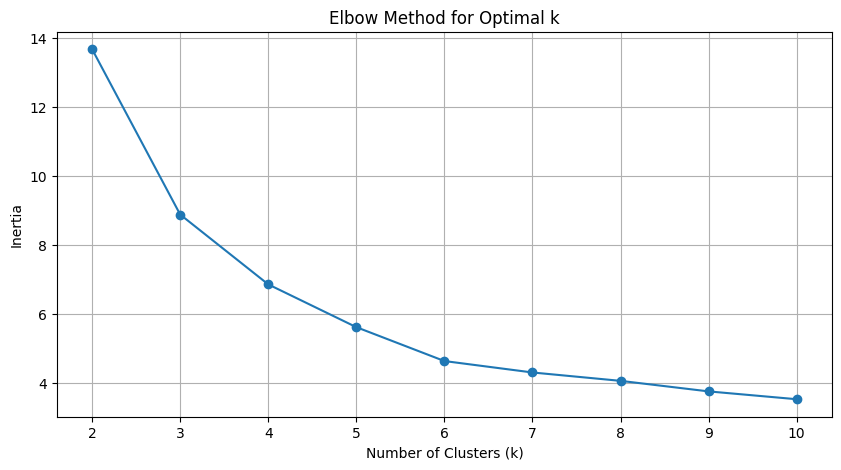

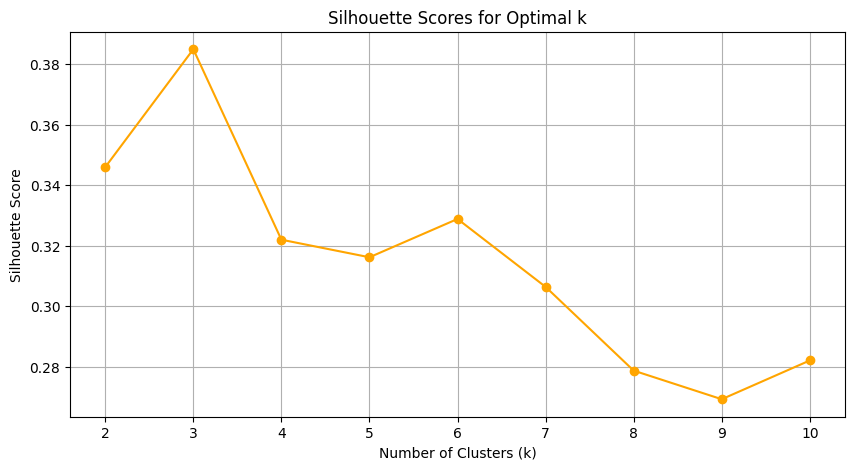

3

In [9]:
inertia = []
silhouette_scores = []
Krange = range(2, 11)

for k in Krange:
    Kmeans = KMeans(n_clusters=k, random_state=42)
    Kmeans.fit(FeaturesNormalized)
    inertia.append(Kmeans.inertia_)
    silhouette_scores.append(silhouette_score(FeaturesNormalized, Kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(Krange, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(Krange, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

OptimalK = silhouette_scores.index(max(silhouette_scores)) + 2
OptimalK

In [10]:
Kmeans = KMeans(n_clusters=OptimalK, random_state=42)
FeaturesNormalized['Cluster'] = Kmeans.fit_predict(FeaturesNormalized)
DBindex = davies_bouldin_score(FeaturesNormalized.iloc[:, :-1], FeaturesNormalized['Cluster'])

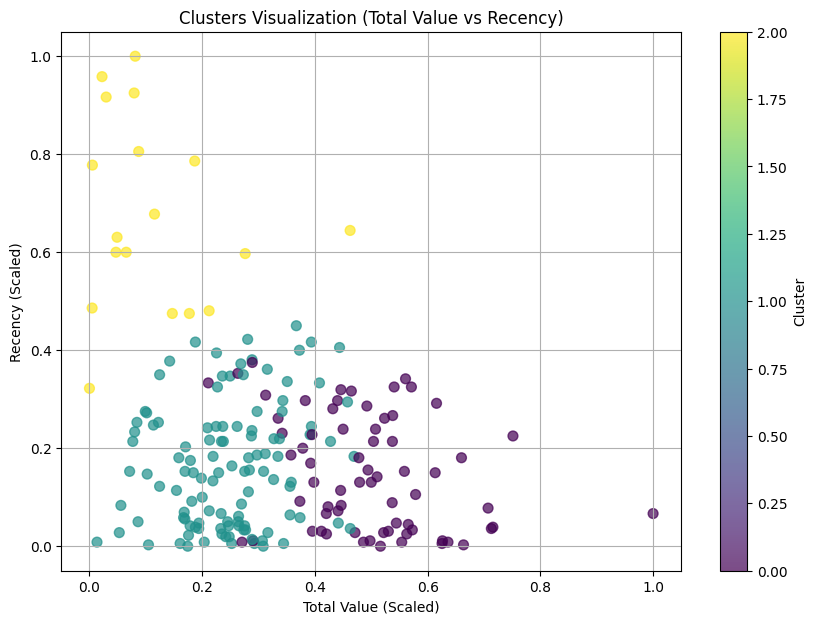

0.8707947670549266


In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(
    FeaturesNormalized['TotalValue'],
    FeaturesNormalized['Recency'],
    c=FeaturesNormalized['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.title('Clusters Visualization (Total Value vs Recency)')
plt.xlabel('Total Value (Scaled)')
plt.ylabel('Recency (Scaled)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

print(DBindex)